In [1]:
import numpy as np
import os

import poppy
import dms # modified gpipsfs DM module (https://github.com/geminiplanetimager/gpipsfs/blob/master/gpipsfs/dms.py)
import pdb

import webbpsf
from webbpsf import wfirst

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

matplotlib.rcParams['font.size'] = 9

import astropy.io
import astropy.units as u
import astropy.io.fits as fits

import scipy.interpolate
import scipy.signal
import scipy.optimize

print("Imported Poppy module from {0:s}".format(os.path.abspath(poppy.__file__)))

Imported Poppy module from /Users/mrizzo/anaconda/lib/python3.5/site-packages/poppy/__init__.py


In [2]:
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/WFIRST/webbpsf-data')
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/WFIRST/webbpsf-data-source')

#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data-source')
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')

#wfemap_path = os.path.expanduser('~/WFIRST/wfemaps/')

In [3]:
webbpsf.setup_logging('ERROR') # Reduce the verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


## Get pixel scale from debris disk imaging SPC model at 661 nm

In [4]:
fov = 3.4 # arcsec
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode)
diskspc.options['source_offset_r'] = 0 # arcsec
diskspc.options['source_offset_theta'] = 0 # deg w.r.t. North

filter_fname = diskspc._filters[diskspc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)

print('{:.1f}% bandpass centered at {:.1f} nm'.format(
100*float(filter_hdulist[1].header.get('DELTALAM'))/float(filter_hdulist[1].header.get('LAMBDA0')),
float(filter_hdulist[1].header.get('LAMBDA0'))/10))

lamoD_asec_F661 = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*diskspc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D): %.5f arcsec" % lamoD_asec_F661)

10.0% bandpass centered at 661.0 nm
System diffraction resolution element scale (lambda_0/D): 0.05681 arcsec


In [5]:
diskspc.calc_psf()

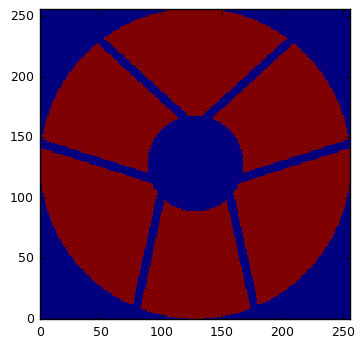

In [6]:
plt.imshow(diskspc.optsys.planes[0].amplitude)

### Set pixelscale to 56.81 mas =  0.25*lambda/D at 661 nm, and FoV to 3.4 arcsec

In [7]:
#cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
diskspc.calc_psf()

## Characterize high spatial frequency OPD map

In [8]:
ho_OPD_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/CGI_static_test_OPD_D256_120pm.fits")
ho_OPD_cube_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/cgi_errormap_zsub_cube_D0256_1500pm_16maps.fits")

ho_OPD = astropy.io.fits.getdata(ho_OPD_cube_fname)[0]
ho_OPD_cube = astropy.io.fits.getdata(ho_OPD_cube_fname)
OPD_header = astropy.io.fits.getheader(ho_OPD_fname)

In [9]:
OPD_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
BUNIT   = 'meter   '                                                            

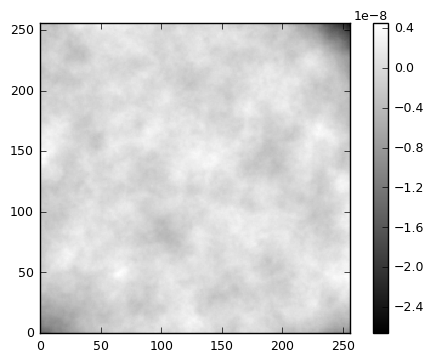

In [10]:
plt.imshow(ho_OPD, cmap='gray')
plt.colorbar()

In [11]:
np.std(ho_OPD)

2.1357646487603626e-09

In [12]:
opd_padded_wfirst = np.zeros((512,512))
mask_padded_wfirst = np.zeros_like(opd_padded_wfirst)
opd_padded_wfirst[128:128+256, 128:128+256] = ho_OPD*diskspc.optsys.planes[0].amplitude[::-1,:]
mask_padded_wfirst[128:128+256, 128:128+256] = diskspc.optsys.planes[0].amplitude[::-1,:]

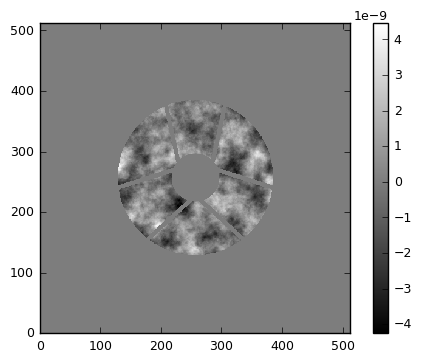

In [13]:
plt.imshow(opd_padded_wfirst, cmap='gray')
plt.colorbar()

In [14]:
np.std(opd_padded_wfirst)

4.7949958789353668e-10

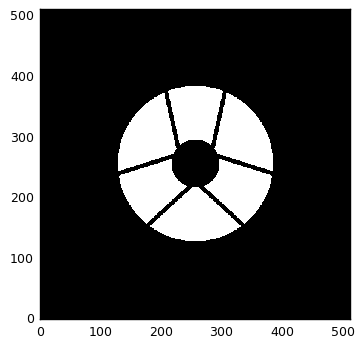

In [15]:
plt.imshow(mask_padded_wfirst, cmap='gray')

In [16]:
nan_ind = (mask_padded_wfirst == 0)
mask_padded_wfirst[nan_ind] = np.nan

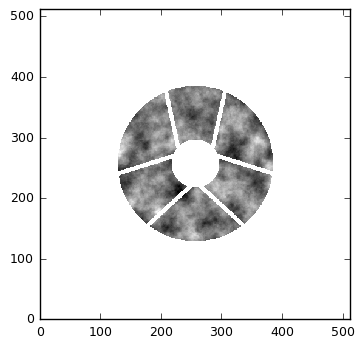

In [17]:
plt.imshow(mask_padded_wfirst*opd_padded_wfirst, cmap='gray')

### RMS wavefront within transmitted region of pupil

In [18]:
np.nanstd(mask_padded_wfirst*opd_padded_wfirst)/1e-12

1189.6093126294475

In [19]:
Phi = 1/(512*512)*np.fft.fftshift(np.fft.fft2(opd_padded_wfirst))

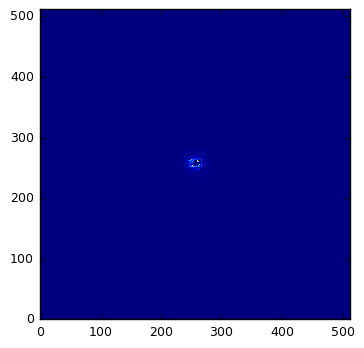

In [20]:
plt.imshow(np.abs(Phi)**2)

In [21]:
np.sqrt(np.sum(np.abs(Phi)**2))

4.7949959300639257e-10

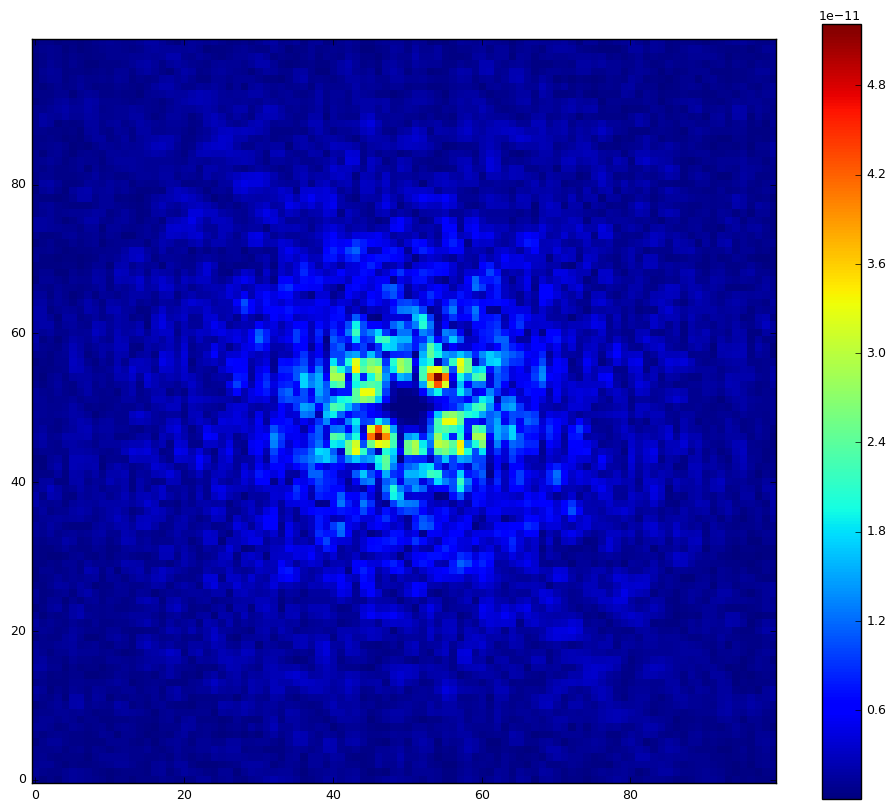

In [22]:
plt.figure(figsize=(12,10))
plt.imshow(np.sqrt(np.abs(Phi[206:306, 206:306])**2))
plt.colorbar()

In [23]:
XX, YY = np.meshgrid(np.arange(512), np.arange(512))
RR = np.sqrt( (XX - 256)**2 + (YY - 256)**2 )

In [24]:
iwa = 12
owa = 20
ring_mask = (RR >= iwa*512/256) & (RR <= owa*512/256)

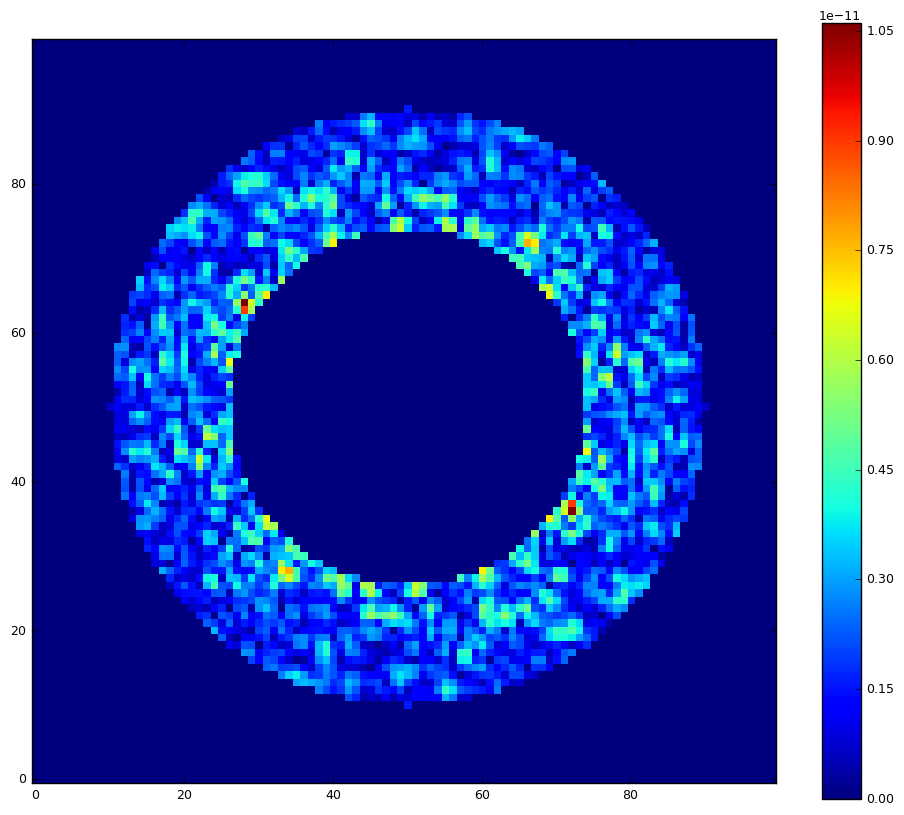

In [25]:
plt.figure(figsize=(12,10))
plt.imshow(np.sqrt(np.abs((ring_mask*Phi)[206:306, 206:306])**2))
plt.colorbar()

### RMS wavefront within range of spatial frequencies, full pupil

In [26]:
np.sqrt(np.sum(np.abs(Phi[ring_mask])**2))/1e-12

145.34108897327121

## Debris disk SPC with high-order OPD map

In [27]:
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'
fov = 3.4

diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
diskspc.options['source_offset_r'] = 0.

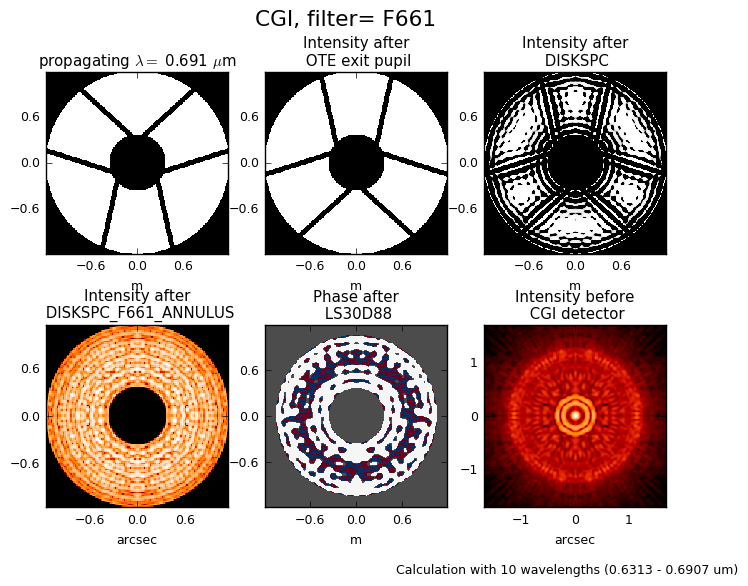

In [28]:
plt.figure(figsize=(8,6))
_, diskspc_zeroab_wfs = diskspc.calc_psf(display=True, return_intermediates=True,
                                         fov_arcsec=fov)

In [29]:
diskspc_zeroab_wfs[-1].pixelscale

<Quantity 0.014202191346805282 arcsec / pix>

In [30]:
diskspc_zeroab_wfs[-1].shape

(240, 240)

### apply high-order OPD in shaped pupil plane

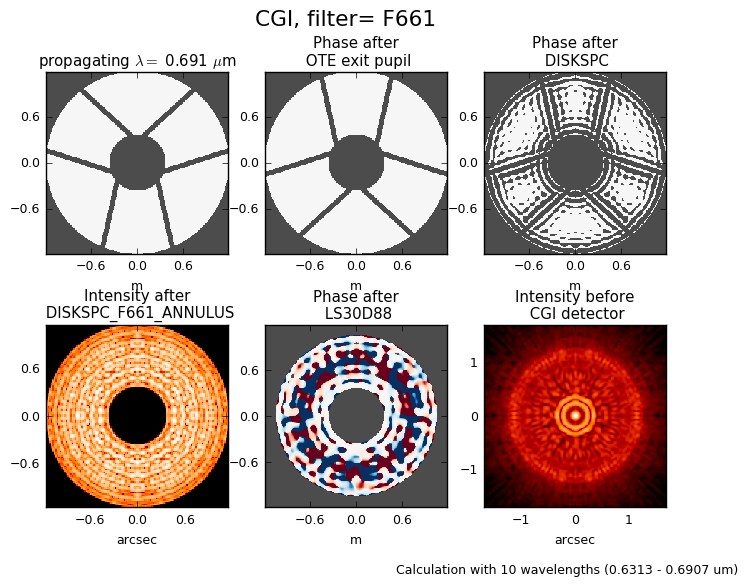

In [31]:
plt.figure(figsize=(8,6))

ho_opd_target = ho_OPD_cube[5]/10 + ho_OPD_cube[6]/40
ho_opd_ref = ho_OPD_cube[5]/10 + ho_OPD_cube[7]/40

diskspc.options['source_offset_r'] = 0.

diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(ho_opd_target[::-1,:], header=OPD_header)])
_, diskspc_hoab_wfs_target = diskspc.calc_psf(display=True, return_intermediates=True,
                                              fov_arcsec=fov)

diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(ho_opd_ref[::-1,:], header=OPD_header)])
_, diskspc_hoab_wfs_ref = diskspc.calc_psf(display=True, return_intermediates=True,
                                           fov_arcsec=fov)

## Off-axis PSF for contrast calibration

In [32]:
dxi = diskspc.pixelscale/diskspc.optsys.oversample
M_fp2 = diskspc_zeroab_wfs[-1].intensity.shape[0]//2
print('oversampled image array half width {:d} points'.format(M_fp2))
print('spatial sampling {:.6} arcsec'.format(dxi))

oversampled image array half width 120 points
spatial sampling 0.0142022 arcsec


In [33]:
xis = np.matrix(np.linspace(-M_fp2+0.5, M_fp2-0.5, 2*M_fp2)*dxi)
xi_ind = 180
print(xis[0, xi_ind])

0.859232576482


In [34]:
diskspc.options['source_offset_r'] = xis[0, xi_ind] # arcsec
diskspc.options['source_offset_theta'] = -90. # deg w.r.t. North
psf_offax = diskspc.calc_psf(display=False, fov_arcsec=fov)
offax_psf_peak = np.max(psf_offax[0].data)

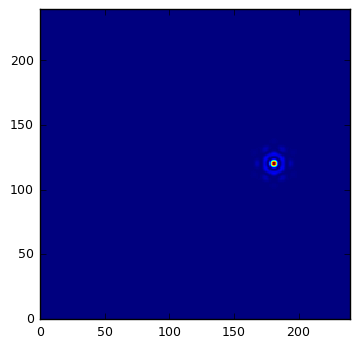

In [35]:
plt.imshow(psf_offax[0].data)

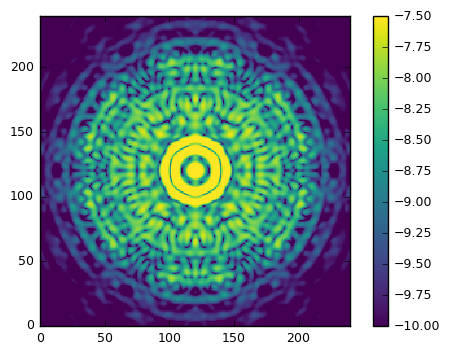

In [36]:
#plt.imshow(np.log10(diskspc_hoab_wfs[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7)
plt.imshow(np.log10(diskspc_zeroab_wfs[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7.5, cmap='viridis')
plt.colorbar()

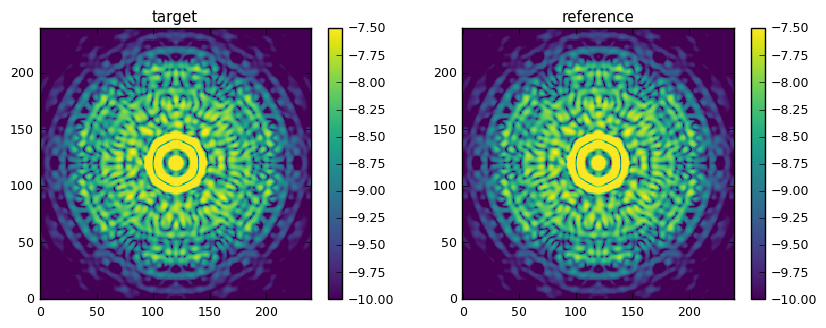

In [37]:
plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(np.log10(diskspc_hoab_wfs_target[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7.5, cmap='viridis')
plt.title('target')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log10(diskspc_hoab_wfs_ref[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7.5, cmap='viridis')
plt.title('reference')
plt.colorbar()

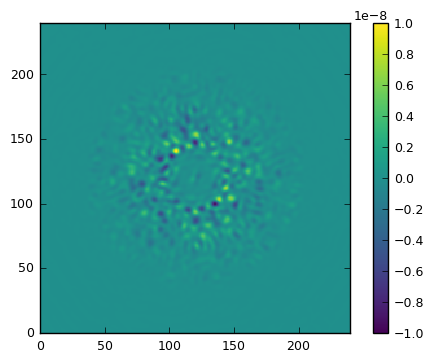

In [38]:
plt.imshow((diskspc_hoab_wfs_target[-1].intensity - diskspc_hoab_wfs_ref[-1].intensity)/offax_psf_peak,
           vmin=-1e-8, vmax=1e-8, cmap='viridis')
plt.colorbar()

In [39]:
XXp, YYp = np.meshgrid(np.arange(2*M_fp2), np.arange(2*M_fp2))
RRp = np.sqrt( (XXp - M_fp2)**2 + (YYp - M_fp2)**2 )
IWAp = 6.5*lamoD_asec_F661/dxi
OWAp = 20.*lamoD_asec_F661/dxi
fov_mask = np.zeros_like(XXp)
fov_ind = (RRp >= IWAp) & (RRp <= OWAp)
fov_mask[fov_ind] = True
fov_mask_nan = np.where(fov_mask, 1, np.nan)
print(IWAp)
print(OWAp)

26.0
80.0


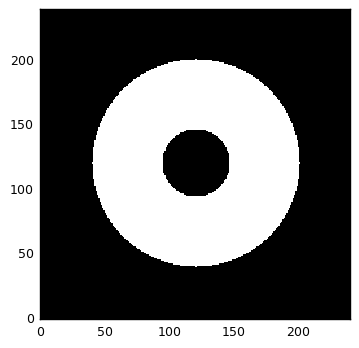

In [40]:
plt.imshow(fov_mask_nan, cmap='gray', vmin=0, vmax=1)

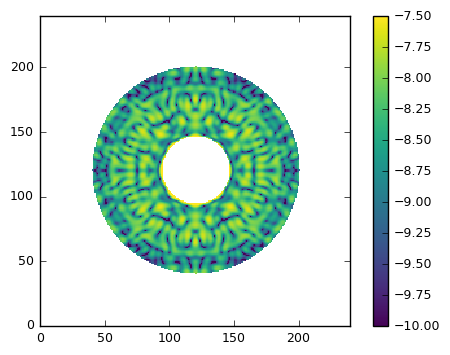

In [41]:
plt.imshow(np.log10(fov_mask_nan*diskspc_zeroab_wfs[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7.5, cmap='viridis')
plt.colorbar()

### residual intensity metrics in FoV

In [42]:
np.nanmean(fov_mask_nan*diskspc_zeroab_wfs[-1].intensity/offax_psf_peak)

5.3621178997297492e-09

In [43]:
np.nanmean(fov_mask_nan*diskspc_hoab_wfs_target[-1].intensity/offax_psf_peak)

5.7710408075058367e-09

In [44]:
np.nanmean(fov_mask_nan*diskspc_hoab_wfs_ref[-1].intensity/offax_psf_peak)

5.7697013339584943e-09

In [45]:
np.nanstd(fov_mask_nan*(diskspc_hoab_wfs_target[-1].intensity -\
                        diskspc_hoab_wfs_ref[-1].intensity)/offax_psf_peak)

9.8024190742839323e-10

### low order error budget

In [46]:
def generate_coefficients(wfe_budget):
    coefficients = []
    for ii, term in enumerate(wfe_budget):
        if ii == 1 or ii ==2:
            coefficients.append(np.random.normal(loc=0, scale=term))
        else:
            coefficients.append(np.random.uniform(low=-term, high=term))
    return coefficients

In [47]:
max_coeff = 21
zern_wfe_budget = np.zeros(max_coeff)
zero_zern_wfe_budget = np.zeros(max_coeff)
zern_wfe_budget[1:3] = 6e-9 # approximately 1 mas pointing error
zern_wfe_budget[3] = 300e-12 # defocus
zern_wfe_budget[4:6] = 150e-12 # astigmatism
zern_wfe_budget[6:8] = 30e-12 # coma
zern_wfe_budget[8:10] = 10e-12 # trefoil
zern_wfe_budget[11:] = 10e-12

In [48]:
rand_zern_coeff = generate_coefficients(zern_wfe_budget)
print(rand_zern_coeff)

[0.0, -1.1303768041017984e-08, -1.0838459428604725e-09, 7.503012465304223e-11, 2.204051707477399e-11, -6.94158519208589e-11, 2.147245074862434e-11, -9.716566768058855e-13, -9.36767550122027e-12, 8.762293522641218e-12, 0.0, 4.496517910401603e-12, -9.00211175350007e-12, -2.6239514779983007e-12, 1.3920042263766003e-12, 3.1664386858897443e-12, -1.4471493985565937e-12, 3.0558421032513215e-13, 6.890580571364182e-12, 7.426754913874752e-12, -9.340706428187647e-12]


In [49]:
zern_optic = poppy.ZernikeWFE(radius=2.37/2, coefficients=rand_zern_coeff)
#zern_optic = poppy.ZernikeWFE(radius=2.37/2, coefficients=[0, 6e-9])
test_zern_opd = zern_optic.get_opd(diskspc_zeroab_wfs[0])

Peak-to-valley WFE: 45.299 nm


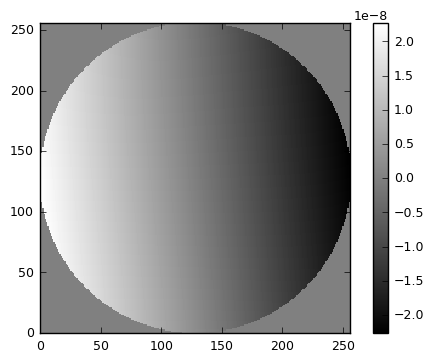

In [50]:
print('Peak-to-valley WFE: {:.3f} nm'.format((np.max(test_zern_opd)-np.min(test_zern_opd))/1e-9))
plt.imshow(test_zern_opd, cmap='gray')
plt.colorbar()

In [51]:
plt.figure(figsize=(8,6))

#ho_opd_target = ho_OPD_cube[5]/10 + ho_OPD_cube[6]/40
#ho_opd_ref = ho_OPD_cube[5]/10 + ho_OPD_cube[7]/40

diskspc.options['source_offset_r'] = 0.

diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(test_zern_opd, header=OPD_header)])
_, diskspc_zernab_wfs = diskspc.calc_psf(display=False, return_intermediates=True,
                                         fov_arcsec=fov)

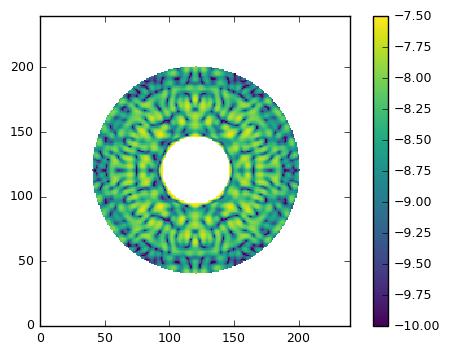

In [52]:
plt.imshow(np.log10(fov_mask_nan*diskspc_zernab_wfs[-1].intensity/offax_psf_peak), vmin=-10, vmax=-7.5, cmap='viridis')
plt.colorbar()

In [53]:
def composite_phase_screen(a1, a2, a3, phi1, phi2, phi3, t, Nt):
    return a1*phi1 + a2*t/(Nt-1)*phi2 + a3*(1 - t/(Nt-1))*phi3

In [54]:
dxi = diskspc.pixelscale/diskspc.optsys.oversample
M_fp2 = diskspc_zeroab_wfs[-1].intensity.shape[0]//2
print('oversampled image array half width {:d} points'.format(M_fp2))
print('spatial sampling {:.6} arcsec'.format(dxi))
xis = np.matrix(np.linspace(-M_fp2+0.5, M_fp2-0.5, 2*M_fp2)*dxi)
xi_ind = 180
print(xis[0, xi_ind])

oversampled image array half width 120 points
spatial sampling 0.0142022 arcsec
0.859232576482


In [55]:
cgi_modes = ['DISKSPC_F661', 'DISKSPC_F721', 'DISKSPC_F883']
fov = 3.4
lamoD_asec_F661 = 0.05680876538722113
Nt = 100

a1 = 1./2
a2 = 1./2
a3 = a2 

for m, cgi_mode in enumerate(cgi_modes):
    phi1 = 0.1*ho_OPD_cube[3*m] # 120 pm RMS WFE in transmitted part of telescope pupil
    phi2 = 0.2*ho_OPD_cube[3*m+1] # 
    phi3 = 0.1*ho_OPD_cube[3*m+2] #
    
    diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
    
    diskspc.options['source_offset_r'] = xis[0, xi_ind] # arcsec
    diskspc.options['source_offset_theta'] = -90. # deg w.r.t. North
    psf_offax = diskspc.calc_psf(display=False, fov_arcsec=fov)
    offax_psf_peak = np.max(psf_offax[0].data)
    diskspc.options['source_offset_r'] = 0. # arcsec
    
    onax_psf_cube = np.zeros((Nt, diskspc_zeroab_wfs[-1].intensity.shape[0], 
                                  diskspc_zeroab_wfs[-1].intensity.shape[1]))
    onax_psf_diff_cube = np.zeros_like(onax_psf_cube)
    opd_cube = np.zeros((Nt, diskspc_zeroab_wfs[0].amplitude.shape[0], diskspc_zeroab_wfs[0].amplitude.shape[0]))

    onax_psf_cube_fname = '{:s}_onax_psf_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)
    onax_psf_diff_cube_fname = '{:s}_onax_psf_diff_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)
    opd_cube_fname = '{:s}_OPD_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)

    for tt in range(Nt):
        ho_opd = composite_phase_screen(a1, a2, a3, phi1, phi2, phi3, tt, Nt)
        zern_coeff = generate_coefficients(zern_wfe_budget)
#        zern_coeff = generate_coefficients(zero_zern_wfe_budget)
        zern_optic = poppy.ZernikeWFE(radius=diskspc.PUPIL_RADIUS, coefficients=zern_coeff)
        zern_opd = zern_optic.get_opd(diskspc_zeroab_wfs[0])
        opd = zern_opd + ho_opd
    
        diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(opd, header=OPD_header)])
        _, diskspc_onax_ab_wfs = diskspc.calc_psf(display=False, return_intermediates=True,
                                                  fov_arcsec=fov)
        onax_psf_cube[tt] = diskspc_onax_ab_wfs[-1].intensity
        onax_psf_diff_cube[tt] = (onax_psf_cube[tt] - onax_psf_cube[0])/offax_psf_peak
        opd_cube[tt] = opd
    
    print('{:s} off-axis PSF peak {:.6f}'.format(cgi_mode, offax_psf_peak))
    
    onax_psf_cube_hdulist = fits.PrimaryHDU(onax_psf_cube)
    onax_psf_cube_hdulist.writeto(onax_psf_cube_fname, clobber=True)
    print('Wrote on-axis PSF time-series cube to {:s}'.format(onax_psf_cube_fname))
    
    onax_psf_diff_cube_hdulist = fits.PrimaryHDU(onax_psf_diff_cube)
    onax_psf_diff_cube_hdulist.writeto(onax_psf_diff_cube_fname, clobber=True)
    print('Wrote on-axis PSF time-series difference cube to {:s}'.format(onax_psf_diff_cube_fname))
    
    opd_cube_hdulist = fits.PrimaryHDU(opd_cube)
    opd_cube_hdulist.writeto(opd_cube_fname, clobber=True)
    print('Wrote OPD time-series cube to {:s}'.format(opd_cube_fname))

DISKSPC_F661 off-axis PSF peak 0.007526
Wrote on-axis PSF time-series cube to DISKSPC_F661_onax_psf_cube_Nwf100.fits.gz
Wrote on-axis PSF time-series difference cube to DISKSPC_F661_onax_psf_diff_cube_Nwf100.fits.gz
Wrote OPD time-series cube to DISKSPC_F661_OPD_cube_Nwf100.fits.gz
DISKSPC_F721 off-axis PSF peak 0.006357
Wrote on-axis PSF time-series cube to DISKSPC_F721_onax_psf_cube_Nwf100.fits.gz
Wrote on-axis PSF time-series difference cube to DISKSPC_F721_onax_psf_diff_cube_Nwf100.fits.gz
Wrote OPD time-series cube to DISKSPC_F721_OPD_cube_Nwf100.fits.gz
DISKSPC_F883 off-axis PSF peak 0.004263
Wrote on-axis PSF time-series cube to DISKSPC_F883_onax_psf_cube_Nwf100.fits.gz
Wrote on-axis PSF time-series difference cube to DISKSPC_F883_onax_psf_diff_cube_Nwf100.fits.gz
Wrote OPD time-series cube to DISKSPC_F883_OPD_cube_Nwf100.fits.gz


In [56]:
diskspc_zeroab_wfs[0].amplitude.shape[0]

256

In [57]:
diskspc_onax_ab_wfs[-1].shape

(240, 240)

In [58]:
#%ls -lh

## Inspect difference stats

In [59]:
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'

In [60]:
diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)

filter_fname = diskspc._filters[diskspc.filter].filename
filter_hdulist = fits.open(filter_fname)

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*diskspc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D): %.5f arcsec" % lamoD_asec)

System diffraction resolution element scale (lambda_0/D): 0.05681 arcsec


In [61]:
dxi = diskspc.pixelscale/4
XXp, YYp = np.meshgrid(np.arange(2*M_fp2), np.arange(2*M_fp2))
RRp = np.sqrt( (XXp - M_fp2)**2 + (YYp - M_fp2)**2 )
IWAp = 6.5*lamoD_asec/dxi
OWAp = 20.*lamoD_asec/dxi
#OWAp = 9.*lamoD_asec/dxi
fov_mask = np.zeros_like(XXp)
fov_ind = (RRp > IWAp) & (RRp < OWAp)
fov_mask[fov_ind] = True
fov_mask_nan = np.where(fov_mask, 1, np.nan)
print(IWAp, OWAp)

26.0 80.0


In [62]:
onax_psf_diff_cube = fits.getdata('{:s}_onax_psf_diff_cube_Nwf{:d}.fits.gz'.format(cgi_mode, Nt))

/Users/mrizzo/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


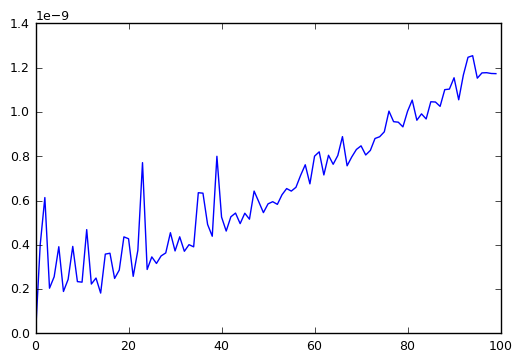

In [63]:
plt.plot(np.nanstd(np.nanstd(np.tile(fov_mask_nan,(Nt,1,1))*onax_psf_diff_cube, axis=-1),
                   axis=-1))

### check the effect of OPDs on an off-axis point source 

In [64]:
cgi_modes = ['DISKSPC_F661']
fov = 3.4
lamoD_asec_F661 = 0.05680876538722113
Nt = 100

a1 = 1./2
a2 = 1./2
a3 = a2 

for m, cgi_mode in enumerate(cgi_modes):
    phi1 = 0.1*ho_OPD_cube[3*m] # 120 pm RMS WFE in transmitted part of telescope pupil
    phi2 = 0.2*ho_OPD_cube[3*m+1] # 
    phi3 = 0.1*ho_OPD_cube[3*m+2] #
    
    diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
    
    diskspc.options['source_offset_r'] = xis[0, xi_ind] # arcsec
    diskspc.options['source_offset_theta'] = -90. # deg w.r.t. North
    psf_offax = diskspc.calc_psf(display=False, fov_arcsec=fov)
    offax_psf_peak = np.max(psf_offax[0].data)
    #diskspc.options['source_offset_r'] = 0. # arcsec
    
    offax_psf_cube = np.zeros((Nt, diskspc_zeroab_wfs[-1].intensity.shape[0], 
                                   diskspc_zeroab_wfs[-1].intensity.shape[1]))
    offax_psf_diff_cube = np.zeros_like(offax_psf_cube)

    offax_psf_cube_fname = '{:s}_offax_psf_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)
    offax_psf_diff_cube_fname = '{:s}_offax_psf_diff_cube_Nwf{:d}.fits.gz'.format(diskspc.mode, Nt)

    for tt in range(Nt):
        ho_opd = composite_phase_screen(a1, a2, a3, phi1, phi2, phi3, tt, Nt)
        zern_coeff = generate_coefficients(zern_wfe_budget)
#        zern_coeff = generate_coefficients(zero_zern_wfe_budget)
        zern_optic = poppy.ZernikeWFE(radius=diskspc.PUPIL_RADIUS, coefficients=zern_coeff)
        zern_opd = zern_optic.get_opd(diskspc_zeroab_wfs[0])
        opd = zern_opd + ho_opd
    
        diskspc.pupilopd = fits.HDUList([fits.PrimaryHDU(opd, header=OPD_header)])
        _, diskspc_offax_ab_wfs = diskspc.calc_psf(display=False, return_intermediates=True,
                                                  fov_arcsec=fov)
        offax_psf_cube[tt] = diskspc_offax_ab_wfs[-1].intensity
        offax_psf_diff_cube[tt] = (offax_psf_cube[tt] - offax_psf_cube[0])/offax_psf_peak
    
    print('{:s} off-axis PSF peak {:.6f}'.format(cgi_mode, offax_psf_peak))
    
    offax_psf_cube_hdulist = fits.PrimaryHDU(offax_psf_cube)
    offax_psf_cube_hdulist.writeto(offax_psf_cube_fname, clobber=True)
    print('Wrote off-axis PSF time-series cube to {:s}'.format(offax_psf_cube_fname))
    
    offax_psf_diff_cube_hdulist = fits.PrimaryHDU(offax_psf_diff_cube)
    offax_psf_diff_cube_hdulist.writeto(offax_psf_diff_cube_fname, clobber=True)
    print('Wrote off-axis PSF time-series difference cube to {:s}'.format(offax_psf_diff_cube_fname))

DISKSPC_F661 off-axis PSF peak 0.007526
Wrote off-axis PSF time-series cube to DISKSPC_F661_offax_psf_cube_Nwf100.fits.gz
Wrote off-axis PSF time-series difference cube to DISKSPC_F661_offax_psf_diff_cube_Nwf100.fits.gz
